In [1]:
import os
import pandas as pd
import supereeg as se
import numpy as np
import copy
import nibabel as nib
from nilearn import plotting as ni_plt
from nilearn.image import resample_img
from nilearn import datasets, image
from scipy.spatial.distance import pdist, cdist
import scipy 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, IncrementalPCA
import matplotlib.colors as mplcol
import matplotlib as mpl
import seaborn as sns
from scipy.io import loadmat

/Users/lucyowen/.pyenv/versions/3.7.2/envs/my-data-project/lib/python3.7/site-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [2]:
def rbf(centers, widths, locs):
    """
    Radial basis function
    Parameters
    ----------
    centers : ndarray
        rbf coordinates (one row per RBF)
    widths : ndarray
        RBF radii
    locs : ndarray
        locations to evaluate the RBFs (one row per location)
        
    Returns
    ----------
    results : ndarray
        Matrix of RBF weights for each RBF (row), at each location (column)
    """    
    weights = np.exp(np.divide(-cdist(locs, centers, metric='euclidean') ** 2, np.tile(np.array(widths, ndmin=2), [locs.shape[0], 1])))
    return weights.T

In [3]:

def _near_neighbor(bo, full_bo): #TODO: should this be part of bo.get_locs() or Brain.__init__, or possibly model.__init__?
    """
    Finds the nearest voxel for each subject's electrode location and uses
    that as revised electrodes location matrix in the prediction.

    Parameters
    ----------

    bo : Brain object
        Brain object to update

    full_bo : Brain object
        Brain object for the nearests locations used to predict


    Returns
    ----------
    bo : Brain object
        A new updated brain object

    """

    nbo = copy.deepcopy(bo) #FIXME: copying is expensive...
    nbo.orig_locs = nbo.locs
    d = cdist(nbo.locs, full_bo.locs, metric='Euclidean')
    for i in range(len(nbo.locs)):
        min_ind = list(zip(*np.where(d == d[i].min())))[0]
        nbo.data.iloc[:, min_ind[0]] = full_bo.data.iloc[:, min_ind[1]]
    return nbo


In [4]:
n_nets = 7

In [5]:
pwd

'/Users/lucyowen/repos/pca_paper-1/code/notebooks'

In [6]:
fig_dir = '../../paper/figs/source/networks'
network_dir = '../../data/yeo_networks'

In [7]:
nii_bo_dir = '../../data/niis'
if not os.path.exists(nii_bo_dir):
    os.makedirs(nii_bo_dir)
pca_nii_bo_dir = os.path.join(nii_bo_dir, 'pcas')
if not os.path.exists(pca_nii_bo_dir):
    os.makedirs(pca_nii_bo_dir)
networks_nii_bo_dir = os.path.join(nii_bo_dir, 'networks')
if not os.path.exists(networks_nii_bo_dir):
    os.makedirs(networks_nii_bo_dir)
    

In [8]:
template = se.helpers._std(res=4)

In [9]:
ddir = '../../data/'

In [10]:
posterior = loadmat(os.path.join(ddir, 'pieman_posterior_K700.mat'))
centers = posterior['posterior']['centers'][0][0][0][0][0]
widths = np.array(list(posterior['posterior']['widths'][0][0][0][0][0][:, 0].T))

In [11]:
yeo_colors = pd.read_fwf(os.path.join(network_dir, 'Yeo2011_' + str(n_nets) + 'Networks_ColorLUT.txt'))
yeo_colors.columns = ["inds", "networks", "x", "y", "z", "labels"]


In [12]:
if n_nets == 17:
    yeo_color_labels = ['visual peripheral', 'visual central', 'somatomotor A', 'somatomotor B', 'dorsal attention A', 
                        'dorsal attention B', 'ventral attention', 'salience', 'limbic A', 'limbic B', 'control C', 
                        'control A', 'control B', 'default D (auditory)', 'default C', 'default A', 'default B']
elif n_nets == 7:
    yeo_color_labels = ['Visual', 'Somatomotor', 'Dorsal Attention', 'Ventral Attention', 'Limbic ',
                        'Frontoparietal', 'Default']
    
yeo_colors['labels'] = yeo_color_labels

In [13]:
network_dir

'../../data/yeo_networks'

In [14]:
yeo_colors

,inds,networks,x,y,z,labels
0,1,7Networks_1,120,18,134,Visual
1,2,7Networks_2,70,130,180,Somatomotor
2,3,7Networks_3,0,118,14,Dorsal Attention
3,4,7Networks_4,196,58,250,Ventral Attention
4,5,7Networks_5,220,248,164,Limbic
5,6,7Networks_6,230,148,34,Frontoparietal
6,7,7Networks_7,205,62,78,Default


In [15]:
yeo_file = os.path.join(network_dir, 'Yeo2011_'+ str(n_nets) + 'Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz')
yeo = se.load(yeo_file)

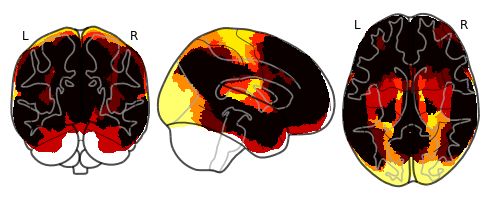

In [16]:
yeo.plot_glass_brain()

In [17]:
downsampled = 4
downsampled_nii = se.Nifti(resample_img(yeo, target_affine=np.eye(3)*downsampled, interpolation='nearest'))

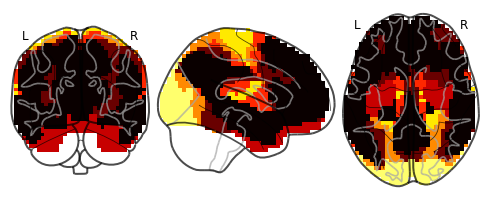

In [18]:
downsampled_nii.plot_glass_brain()

In [69]:
# template = se.helpers._std(res=4)

In [19]:
# template.get_locs()

In [20]:
yeo_bo = se.Brain(downsampled_nii)

In [21]:
yeo_bo.get_locs()

,x,y,z
0,-68.0,-49.0,0.0
1,-68.0,-49.0,4.0
2,-68.0,-45.0,-8.0
3,-68.0,-45.0,-4.0
4,-68.0,-45.0,0.0
...,...,...,...
16452,68.0,-9.0,28.0
16453,68.0,-5.0,12.0
16454,68.0,-5.0,16.0
16455,68.0,-5.0,20.0


In [22]:
networks_nii_bo_dir

'../../data/niis/networks'

In [23]:
yeo_bo.save(os.path.join(networks_nii_bo_dir, 'yeo_bo.bo'))

In [24]:
# magma_colors = np.array([[0.368733  , 0.002724  , 0.650601  ],
#        [0.50022302, 0.01389304, 0.65714894],
#        [0.6201179 , 0.09824851, 0.61470924],
#        [0.86846771, 0.37314094, 0.39753518],
#        [0.93002341, 0.47633225, 0.32375425],
#        [0.97434661, 0.58904578, 0.24948002],
#        [0.99401233, 0.70882914, 0.18102124]])
# magma_colors.shape

In [25]:
### Just for 17! 
# magma_colors = color_stacked/255

In [26]:
# data_vals = yeo_bo.get_data().values.tolist()
# color_all = np.array([])
# for i, v in enumerate(data_vals[0]):
#     ind_color = int(v-1)
#     if color_all.shape[0]==0:
#         color_all = magma_colors[ind_color]
#     else:
#         color_all = np.vstack((color_all, magma_colors[ind_color]))


In [27]:

color_stacked = np.array([])
for i in np.arange(0,n_nets+1):
    if color_stacked.shape[0]==0:
        color_stacked = yeo_colors[yeo_colors.inds==i][['x', 'y', 'z']].values
    else:
        color_stacked = np.vstack((color_stacked, yeo_colors[yeo_colors.inds==i][['x', 'y', 'z']].values))
color_stacked = color_stacked/255

In [28]:
color_stacked

array([[0.47058824, 0.07058824, 0.5254902 ],
       [0.2745098 , 0.50980392, 0.70588235],
       [0.        , 0.4627451 , 0.05490196],
       [0.76862745, 0.22745098, 0.98039216],
       [0.8627451 , 0.97254902, 0.64313725],
       [0.90196078, 0.58039216, 0.13333333],
       [0.80392157, 0.24313725, 0.30588235]])

In [29]:
data_vals = yeo_bo.get_data().values.tolist()
color_all = np.array([])
for i, v in enumerate(data_vals[0]):
    ind_color = int(v-1)
    if color_all.shape[0]==0:
        color_all = color_stacked[ind_color]
    else:
        color_all = np.vstack((color_all, color_stacked[ind_color]))
        

In [31]:
color_all.shape

(16457, 3)

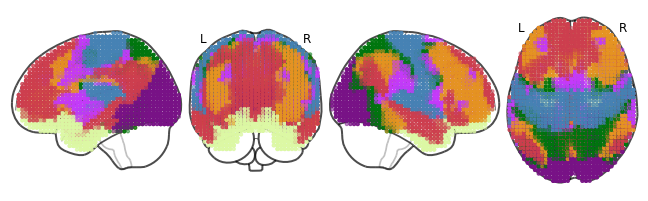

In [32]:
yeo_all_locs = yeo_bo.get_locs().values
ni_plt.plot_connectome(np.eye(yeo_all_locs.shape[0]), yeo_all_locs, output_file=None,
                               node_kwargs={'alpha': 0.5, 'edgecolors': None},
                               node_size=10, node_color=color_all, display_mode='lyrz')



In [33]:
yeo_all_locs.shape

(16457, 3)

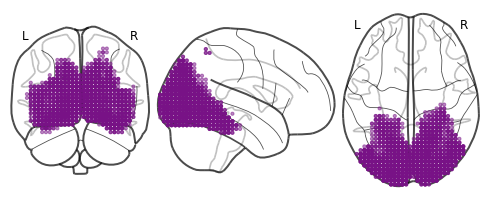

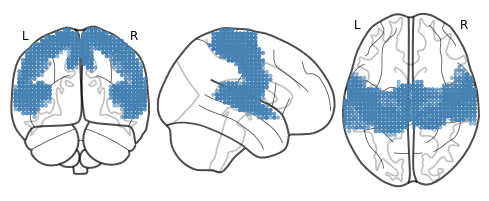

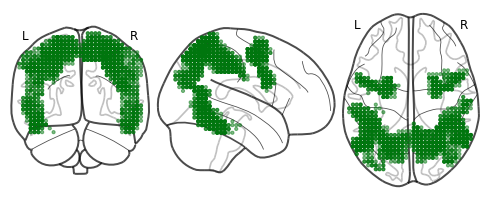

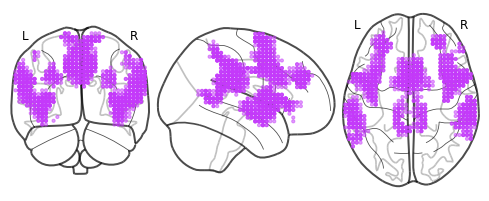

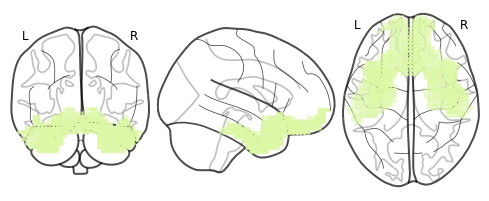

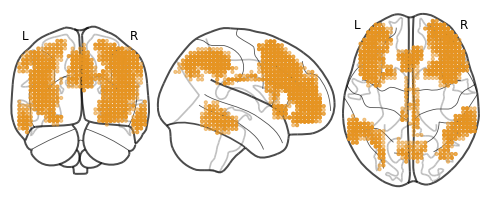

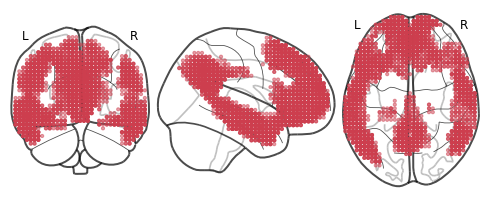

In [34]:
for n in np.arange(1, n_nets+1):
    mask_n = yeo_bo.get_data()==n
    masked_locs = yeo_bo.get_locs().values[mask_n.values.ravel()]
    bo_n = se.Brain(data=np.atleast_2d(np.ones(masked_locs.shape[0])), locs=masked_locs)
    locs = bo_n.get_locs().values
    #colors = magma_colors[n-1]
    #colors = color_stacked[n-1]
    colors = color_all[mask_n.values.ravel()]
    ni_plt.plot_connectome(np.eye(locs.shape[0]), locs, output_file=None,
                                   node_kwargs={'alpha': 0.5, 'edgecolors': None},
                                   node_size=10, node_color=colors)
    outfile = os.path.join(networks_nii_bo_dir, 'bo_network_' + str(n))
    bo_n.save(outfile)

In [35]:
yeo_nii = se.load(os.path.join(networks_nii_bo_dir, 'yeo_bo.bo'), return_type='nii', vox_size=4)




In [36]:
yeo_bo = se.load(os.path.join(networks_nii_bo_dir, 'yeo_bo.bo'))

In [37]:
yeo_bo.get_data()

,0,1,2,3,4,5,6,7,8,9,...,16447,16448,16449,16450,16451,16452,16453,16454,16455,16456
0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,2.0,4.0,7.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


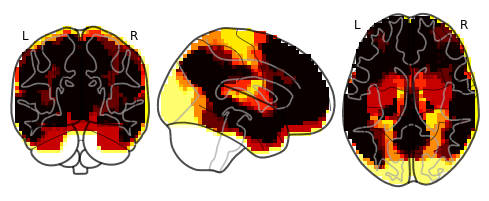

In [38]:
yeo_nii.plot_glass_brain()

In [39]:
yeo_nii.get_locs()

,x,y,z
0,-68.0,-48.0,-2.0
1,-68.0,-48.0,2.0
2,-68.0,-48.0,6.0
3,-68.0,-44.0,-10.0
4,-68.0,-44.0,-6.0
...,...,...,...
21856,72.0,-4.0,10.0
21857,72.0,-4.0,14.0
21858,72.0,-4.0,18.0
21859,72.0,-4.0,22.0


In [40]:
temp_locs = centers
temp_widths = widths
w = rbf(temp_locs, temp_widths, yeo_bo.get_locs().values)
b_o = se.Brain(data=np.array(np.sum(w, axis=0), ndmin=2), locs= yeo_bo.get_locs().values, minimum_voxel_size=4)


In [41]:
centers_bo = se.Brain(data=np.ones((1, centers.shape[0])), locs=centers)

In [42]:
centers_bo = copy.deepcopy(centers_bo) #FIXME: copying is expensive...
centers_bo.orig_locs = centers_bo.locs

In [43]:
centers_bo

In [44]:
d = cdist(centers_bo.locs, yeo_bo.locs, metric='Euclidean')

In [45]:
d

array([[105.65587156, 105.96365039, 103.73875515, ...,  47.66009474,
         49.64490547,  51.86278673],
       [ 16.0996548 ,  16.44499263,  19.0411581 , ..., 129.34342696,
        129.88056435, 130.53811663],
       [114.9672137 , 115.25712161, 115.54629781, ...,  70.97542577,
         72.33432738,  73.88503754],
       ...,
       [137.83468979, 136.71156984, 138.90371108, ...,  30.93462097,
         27.8675868 ,  25.06499579],
       [ 43.84732542,  40.92762494,  48.16733672, ..., 126.10660648,
        125.63183806, 125.28304463],
       [ 60.83374809,  59.71577404,  60.38724779, ..., 117.01374958,
        116.98481249, 117.09259206]])

In [47]:
for i in range(len(centers_bo.locs)):
    min_ind = list(zip(*np.where(d == d.min())))[0]
    centers_bo.locs.iloc[min_ind[0], :] = yeo_bo.locs.iloc[min_ind[1], :]
    centers_bo.data.iloc[:, min_ind[0]] = yeo_bo.data.iloc[:, min_ind[1]]
    d[min_ind[0]] = np.inf
    d[:, min_ind[1]] = np.inf

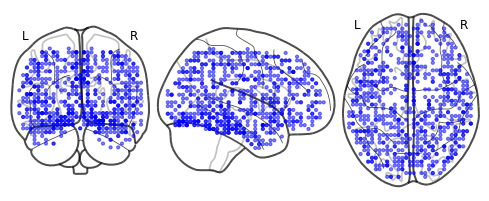

In [48]:
centers_bo.plot_locs()

In [49]:
centers_bo.data

,0,1,2,3,4,5,6,7,8,9,...,690,691,692,693,694,695,696,697,698,699
0,4.0,7.0,1.0,6.0,4.0,6.0,1.0,4.0,5.0,5.0,...,1.0,1.0,1.0,4.0,5.0,2.0,2.0,3.0,4.0,6.0


In [50]:
all_inds = se.helpers.get_rows(b_o.locs.values, centers_bo.locs.values)



In [51]:
all_inds

[12645,
 1238,
 13532,
 7627,
 8703,
 9184,
 6721,
 3838,
 4694,
 8287,
 16109,
 2496,
 13983,
 11110,
 4600,
 7866,
 13291,
 15858,
 9657,
 5848,
 12451,
 13189,
 3281,
 8993,
 12324,
 8545,
 2356,
 1891,
 15049,
 4923,
 8714,
 12004,
 4768,
 7631,
 14281,
 9806,
 5307,
 3965,
 13444,
 2216,
 8424,
 11292,
 6393,
 5275,
 13506,
 2273,
 15501,
 10351,
 4190,
 3527,
 6046,
 1345,
 14523,
 12098,
 420,
 8192,
 9710,
 8492,
 16103,
 3165,
 10139,
 15492,
 4962,
 1086,
 7415,
 10870,
 10758,
 14496,
 15257,
 2702,
 15388,
 8755,
 9035,
 3713,
 10396,
 10566,
 5851,
 1979,
 14226,
 6872,
 975,
 14012,
 7119,
 9443,
 12647,
 9560,
 7546,
 5589,
 13060,
 12044,
 3470,
 6183,
 5990,
 12582,
 13161,
 11531,
 2743,
 5170,
 8898,
 2393,
 754,
 2018,
 1234,
 14159,
 5903,
 1323,
 6001,
 1204,
 11238,
 5241,
 15445,
 6412,
 12194,
 7233,
 6338,
 11362,
 8683,
 537,
 7578,
 840,
 6201,
 13387,
 14459,
 10303,
 5016,
 1045,
 1492,
 6810,
 8351,
 2503,
 4928,
 10755,
 13811,
 700,
 6777,
 8092,
 11222

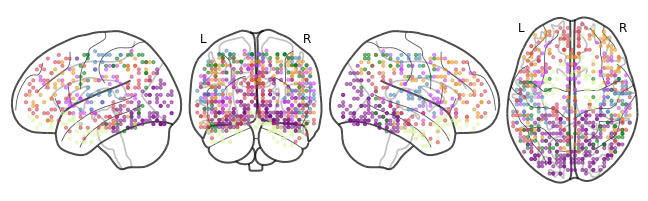

In [52]:
#yeo_all_locs = yeo_bo.get_locs().as_matrix()
ni_plt.plot_connectome(np.eye(b_o.locs.values[all_inds].shape[0]), b_o.locs.values[all_inds], output_file=None,
                               node_kwargs={'alpha': 0.5, 'edgecolors': None},
                               node_size=10, node_color=color_all[all_inds], display_mode='lyrz')



In [53]:
networks_bo = centers_bo

In [54]:
network_bo_outfile = os.path.join(network_dir, 'networks.npz')

np.savez(network_bo_outfile, locs=networks_bo.locs.values, data=networks_bo.data.values)


(182, 3)
(58, 3)
(63, 3)
(82, 3)
(77, 3)
(95, 3)
(143, 3)


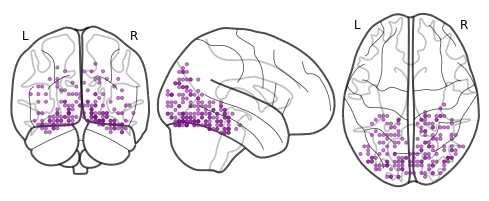

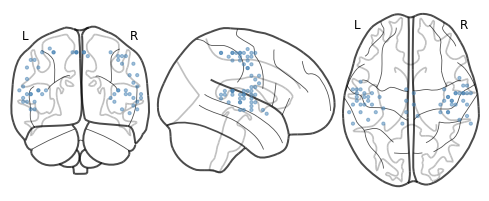

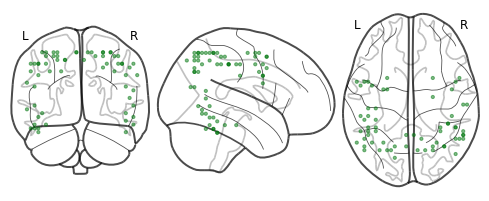

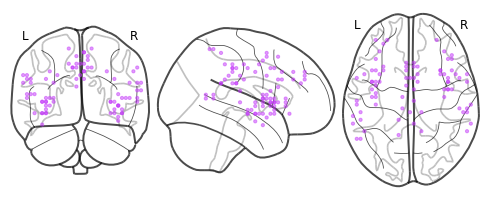

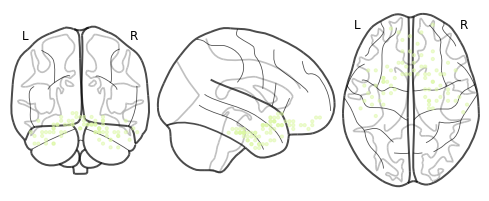

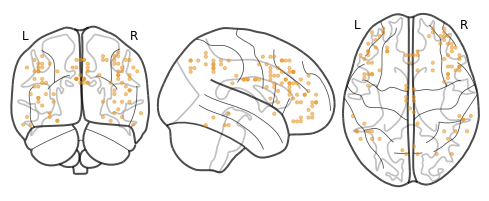

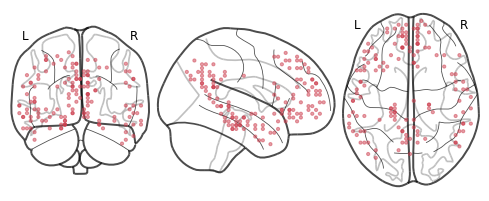

In [59]:
for n in np.arange(1, n_nets+1):
    mask_n = networks_bo.get_data()==n
    masked_locs = networks_bo.get_locs().values[mask_n.values.ravel()]
    bo_n = se.Brain(data=np.atleast_2d(np.ones(masked_locs.shape[0])), locs=masked_locs)
    locs = bo_n.get_locs()
    print(locs.shape)
    colors = color_stacked[n-1]
    repeats_colors = np.tile(colors, (locs.shape[0], 1))
    ni_plt.plot_connectome(np.eye(locs.shape[0]), locs, output_file=None,
                                   node_kwargs={'alpha': 0.5, 'edgecolors': None},
                                   node_size=10, node_color=repeats_colors)
